In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import random
from functools import partial
from tqdm import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Introduction

This notebook is a tutorial based on Engels et al. "Not All Language Model Features Are Linear" (https://arxiv.org/abs/2405.14860)

# Toy Case

The content of this section corresponds to Appendix D in the paper.

## Single Circular Features

In this section we train an (sparse) autoencoder on data points that are distributed uniformly along the unit circle. This serves to build some intution and specify some terms. Feel free to skip this if you feel comfortable with how the basics of how the SAE's work.

*TODO:* what is the take-away here? Maybe add something to show that a single dimension is not sufficient

### Complete Case

We begin with a trivial example to gain basic intuition on the feature vectors of a trained SAE. We generate random samples of points on the unit circle. Then we train a SAE with two features on this data. 

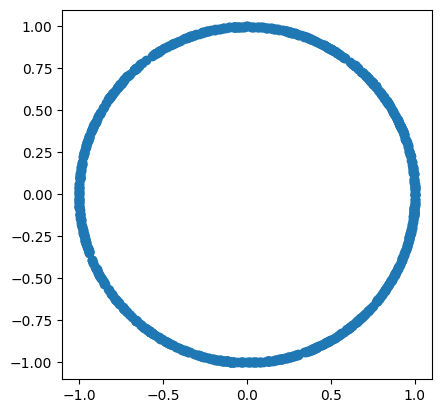

In [3]:
def random_points_on_unit_circle(N, offset=(0, 0)):
  angles = 2 * np.pi * np.random.rand(N)
  x = np.cos(angles) + offset[0]
  y = np.sin(angles) + offset[1]
  return np.column_stack((x, y))

unit_circle_points = random_points_on_unit_circle(1000)
plt.scatter(unit_circle_points[:, 0], unit_circle_points[:, 1])
plt.gca().set_aspect('equal')
plt.show()

In [155]:
class SAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, normalize_dec=False):
    super(SAE, self).__init__()
    self.encoder       = nn.Linear(input_dim, hidden_dim)
    self.decoder       = nn.Linear(hidden_dim, input_dim)
    self.normalize_dec = normalize_dec

  @property
  def dict_elements(self):
    return self.decoder.weight / mx.linalg.norm(self.decoder.weight, axis=0, keepdims=True)

  def __call__(self, x):
    # TOUNDERSTAND: Why do we subtract the bias?
    features = nn.relu(self.encoder(x - self.decoder.bias))
    return features, self.decoder(features)

  def draw_dict_elements(self, plt):
    dict_elements = self.dict_elements
    for i in range(dict_elements.shape[1]):
      plt.quiver(0, 0, dict_elements[0, i], dict_elements[1, i], angles='xy', scale_units='xy', scale=1, color='r')

  def loss_fn(self, X, sparsity_penalty):
    features, reconst = self(X)
    recon_loss        = mx.mean(mx.power(reconst-X, 2), axis=1)
    sparsity_loss     = mx.sum(mx.abs(features), axis=1)
    return mx.mean(recon_loss + sparsity_penalty*sparsity_loss)

  def train(self, Xs, sparsity_penalty, lr=1e-3, max_iter=20000, batch_size=16):
    """
    Xs: list of input datasets, they will be sampled uniformly
    """
    mx.eval(self.parameters())
    loss_and_grad_fn = nn.value_and_grad(self, partial(self.loss_fn, sparsity_penalty=sparsity_penalty))
    optimizer        = optim.Adam(learning_rate=lr)

    if not isinstance(Xs, list):
      Xs = [Xs]

    with tqdm(total=max_iter, desc="Training", unit="iter") as pbar:
      for i in range(max_iter):
        X           = random.choice(Xs)      # why we do this will become clear later
        batch_idx   = np.random.choice(len(X), batch_size)
        x           = mx.array(X[batch_idx])
        loss, grads = loss_and_grad_fn(x)

        if i % 100 == 0:
          pbar.set_postfix({"Loss": loss.item()})

        optimizer.update(self, grads)
        mx.eval(self.parameters(), optimizer.state)

        pbar.update(1)
    

Next we train a SAE which has input and hidden dimension of 2.

Training: 100%|██████████| 20000/20000 [00:19<00:00, 1020.81iter/s, Loss=0.00149]


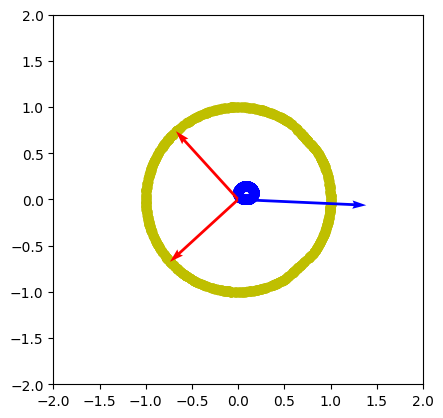

In [140]:
unit_circle_sae = SAE(2, 2)
# Paper uses sparsity penalty of 0.1, this did not work for me. Reconstruction resulted in two lines and a half-circle
# you should be seeing a loss of around 0.02, if it's much higher rerun the training
unit_circle_sae.train(unit_circle_points, sparsity_penalty=0.01, lr=1e-3, batch_size=256)

unit_circle_points_features, unit_circle_points_reconst = unit_circle_sae(mx.array(unit_circle_points))
plt.scatter(unit_circle_points_features[:, 0], unit_circle_points_features[:, 1], color="b")
plt.scatter(unit_circle_points_reconst[:, 0], unit_circle_points_reconst[:, 1], color="y")

unit_circle_sae.draw_dict_elements(plt)
plt.quiver(0, 0, unit_circle_sae.decoder.bias[0], unit_circle_sae.decoder.bias[1], angles='xy', scale_units='xy', scale=1, color='b')

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')
plt.show()

#### Terminology

* features
* activations
* dictionary elements

#### Over-complete Case

Training: 100%|██████████| 20000/20000 [00:18<00:00, 1098.49iter/s, Loss=0.047] 


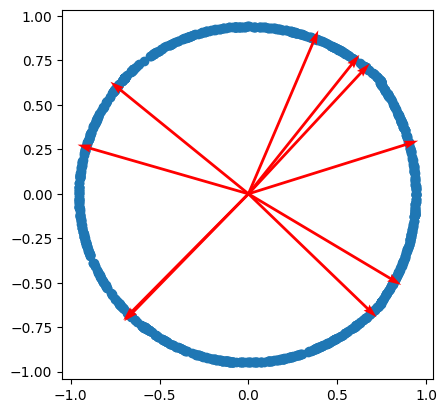

In [54]:
unit_circle_over_complete_sae = SAE(2, 10)
unit_circle_over_complete_sae.train(unit_circle_points, sparsity_penalty=0.1, lr=1e-4, max_iter=20000, batch_size=256)

unit_circle_points_over_complete_features, unit_circle_points_over_complete_reconst = unit_circle_over_complete_sae(mx.array(unit_circle_points))
plt.scatter(unit_circle_points_over_complete_reconst[:, 0], unit_circle_points_over_complete_reconst[:, 1])
unit_circle_over_complete_sae.draw_dict_elements(plt)

plt.gca().set_aspect('equal')
plt.show()

### Details

* investigate the norm of the feature

### Discussion

* SAE's reconstruct the input data
* Not sure what the over-complete case is included in the paper.

Some open questions:
* In the complete case the activations consistently have two flat edges. Why is this?
* Why do the hyperparameters from the paper not reproduce?
* Why is are the activations shifted from the origin in the complete case, but not in the over-complete case?

## Multiple Circular Features

In the previous section we only had one feature which was represented by two directions in feature space. In this next step we want to show how use a SAE to distinguish two such features.

The setup is as follows: We generate two unit circles that we embed in a higher dimensional space (R^10 in this case). We then train a SAE on this data. Assuming that it represents the data well (spoiler: it will), the question is then how do we disentangle the two features based on the internal activations.

Ideally we will two disjoint sets of directions in feature space. Each one corresponding to one of the two circles. Again assuming this to be the case we will apply the following method:
1. cluster the features using the pair-wise angular similarities into two clusters
2. generate a large number of feature activations and for each cluster only retain the input samples that activated at least one feature
3. for each of the input samples set the features that are not in the cluster to zero
4. this should reconstruct the two input circles

In [156]:
def embed_random_points_on_unit_circle(N, M, dims):
    """
    Generate N random points on a unit circle embedded in an M-dimensional space.

    Parameters:
    N (int): Number of points to generate.
    M (int): Dimensionality of the space.
    dims (tuple): Indices of the dimensions in which the circle lies.

    Returns:
    np.ndarray: An array of shape (N, M) containing the random points.
    """
    angles = 2 * np.pi * np.random.rand(N)
    x = np.cos(angles)
    y = np.sin(angles)

    points = np.zeros((N, M))
    points[:, dims[0]] = x
    points[:, dims[1]] = y
    return points

unit_circle1_in_high_dimensions = embed_random_points_on_unit_circle(1000, 10, (0, 1))
unit_circle2_in_high_dimensions = embed_random_points_on_unit_circle(1000, 10, (2, 3))

high_dimensions_sae = SAE(10, 64)
high_dimensions_sae.train([unit_circle1_in_high_dimensions, unit_circle2_in_high_dimensions], sparsity_penalty=0.01, lr=1e-3, batch_size=128)

Training: 100%|██████████| 20000/20000 [00:21<00:00, 941.67iter/s, Loss=0.00109]


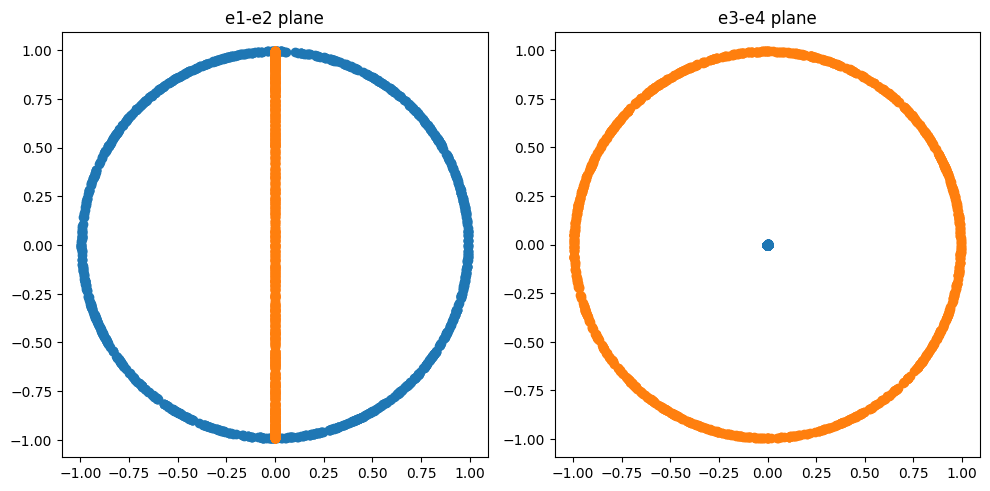

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

recon_unit_circle1_in_high_dimensions = high_dimensions_sae(mx.array(unit_circle1_in_high_dimensions))[1]
recon_unit_circle2_in_high_dimensions = high_dimensions_sae(mx.array(unit_circle2_in_high_dimensions))[1]

axs[0].scatter(recon_unit_circle1_in_high_dimensions[:, 0], recon_unit_circle1_in_high_dimensions[:, 1])
axs[0].scatter(recon_unit_circle2_in_high_dimensions[:, 0], recon_unit_circle1_in_high_dimensions[:, 1])
axs[0].set_aspect('equal')
axs[0].set_title('e1-e2 plane')

axs[1].scatter(recon_unit_circle1_in_high_dimensions[:, 2], recon_unit_circle1_in_high_dimensions[:, 3])
axs[1].scatter(recon_unit_circle2_in_high_dimensions[:, 2], recon_unit_circle2_in_high_dimensions[:, 3])
axs[1].set_aspect('equal')
axs[1].set_title('e3-e4 plane')

plt.tight_layout()
plt.show()

We continue looking only at alive features. The goal of the sparse autoencoder is to learn a sparse dictionary. That means for most inputs only a small number of features should be active, ie have a magnitude > 0. To find these we take our input data and generate a large number of feature activations to observe which dimensions are activated.

*Think about* what are the requirements for the input data to determine alive features.

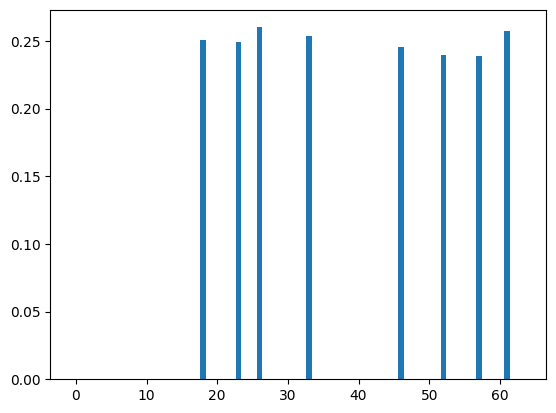

In [158]:
high_dimensions_activations = high_dimensions_sae(mx.concatenate([mx.array(unit_circle1_in_high_dimensions), mx.array(unit_circle2_in_high_dimensions)]))[0]
high_dimensions_active_frac = np.array(mx.mean(mx.abs(high_dimensions_activations) > 1e-8, axis=0))
high_dimensions_active_idxs = np.where(high_dimensions_active_frac > 1e-8)[0]
plt.bar(np.arange(64), high_dimensions_active_frac)
plt.show()

We start with a sanity check. The input data is aligned to two planes, therefore if we got a clean separation between the two features we should see two planes in the activations.

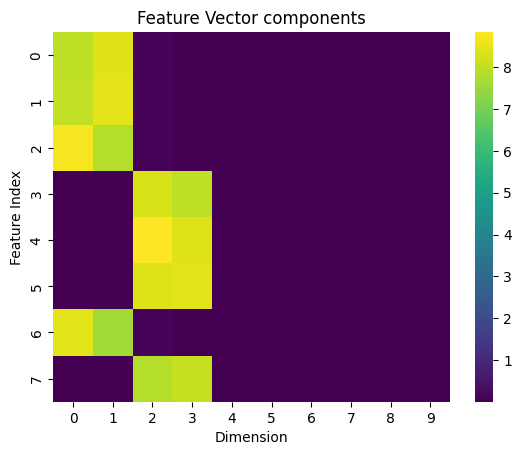

In [195]:
high_dimensions_sae_alive_features = np.array(high_dimensions_sae.decoder.weight)[:, high_dimensions_active_idxs]
sns.heatmap(np.abs(high_dimensions_sae_alive_features.T), annot=False, cmap='viridis', linewidths=0)
plt.title('Feature Vector components')
plt.xlabel('Dimension')
plt.ylabel('Feature Index')
plt.show()

In the graph above we clearly see that the feature vectors are mostly aligned with e1-e2 & e3-e4 basis vectors.

Now we proceed to cluster the feature vectors in the paper this is done using cosine similarity. I was not able to reproduce this. In the paper the number of alive features (Figure 11) is much larger ie around 35 vs. 8 in the above. To proceed we use a different clustering based on Jaccard similarity (also known as IOU similarity). This is also mentioned in the paper, but not used in this case.

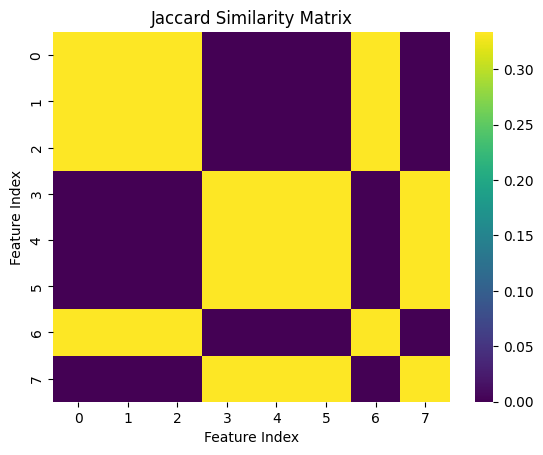

In [174]:
def jaccard_matrix(X):
  intersection = np.dot(X, X.T)
  union        = X.sum(axis=1, keepdims=True) + X.sum(axis=1) - intersection
  return intersection / union

sns.heatmap(jaccard_matrix(np.abs(high_dimensions_sae_alive_features.T) > 0.1), annot=False, cmap='viridis', linewidths=0)
plt.title('Jaccard Similarity Matrix')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()

In [199]:
from sklearn.cluster import AgglomerativeClustering

high_dimensions_feature_clustering = AgglomerativeClustering(n_clusters=2)
high_dimensions_feature_clustering.fit(1 - jaccard_matrix(np.abs(high_dimensions_sae_alive_features.T) > 0.1))

high_dimension_zero_features_idxs = high_dimensions_active_idxs[high_dimensions_feature_clustering.labels_ == 0]
high_dimension_one_features_idxs  = high_dimensions_active_idxs[high_dimensions_feature_clustering.labels_ == 1]

# get the plane for the two clusters. We do this by getting the indices of the two largest components of the feature vectors
def topk_component_idx(features, k):
  c = np.sum(np.abs(features), axis=0)
  return np.argsort(c)[-k:]

high_dimension_zero_plane = topk_component_idx(np.array(high_dimensions_sae.decoder.weight).T[high_dimension_zero_features_idxs], 2)
high_dimension_one_plane  = topk_component_idx(np.array(high_dimensions_sae.decoder.weight).T[high_dimension_one_features_idxs], 2)

Using the clustering we now have two sets of vectors that correspond to the two features, ie the two unit circles of our input data. We now show that these feature clusters are sufficient to reconstruct the relevant features of the input data.

The approach is the following:
1. in activations we used to identify the alive features, we now search for all samples that activate at least one of the features in a cluster. We ignore any samples that activate no feature.
2. for each activation, we set the features that are not in the cluster to zero
3. then reconstruct the input using the weights and bias from the decoder

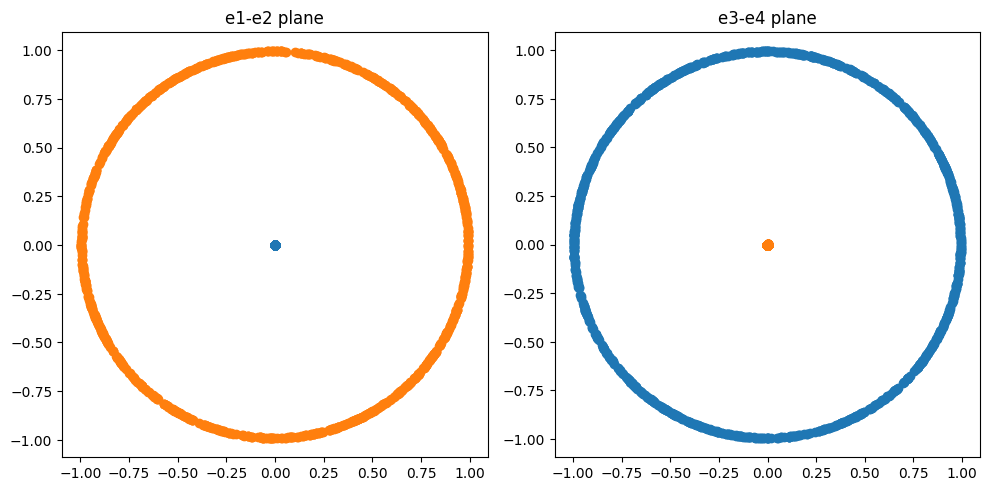

In [218]:
# find all the activations that activate at least one of the features in each cluster, create a copy of the array
high_dimension_zero_samples_idxs = np.where(np.sum(np.array(high_dimensions_activations)[:, high_dimension_zero_features_idxs], axis=1) > 0.01)[0]
high_dimension_one_samples_idxs  = np.where(np.sum(np.array(high_dimensions_activations)[:, high_dimension_one_features_idxs], axis=1) > 0.01)[0]
high_dimension_zero_activations  = np.array(high_dimensions_activations)[high_dimension_zero_samples_idxs].copy()
high_dimension_one_activations   = np.array(high_dimensions_activations)[high_dimension_one_samples_idxs].copy()

# find the indices of all features not part of each cluster and set them to zero in the activations copy
high_dimension_not_zero_features_idxs = np.setdiff1d(np.arange(high_dimensions_activations.shape[1]), high_dimension_zero_features_idxs)
high_dimension_not_one_features_idxs  = np.setdiff1d(np.arange(high_dimensions_activations.shape[1]), high_dimension_one_features_idxs)
high_dimension_zero_activations[:, high_dimension_not_zero_features_idxs] = 0
high_dimension_one_activations[:, high_dimension_not_one_features_idxs]   = 0

# reconstruct & plot the samples
high_dimensions_zero_reconst = high_dimensions_sae.decoder(mx.array(high_dimension_zero_activations))
high_dimensions_one_reconst  = high_dimensions_sae.decoder(mx.array(high_dimension_one_activations))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(high_dimensions_zero_reconst[:, 0], high_dimensions_zero_reconst[:, 1])
axs[0].scatter(high_dimensions_one_reconst[:, 0], high_dimensions_one_reconst[:, 1])
axs[0].set_aspect('equal')
axs[0].set_title('e1-e2 plane')

axs[1].scatter(high_dimensions_zero_reconst[:, 2], high_dimensions_zero_reconst[:, 3])
axs[1].scatter(high_dimensions_one_reconst[:, 2], high_dimensions_one_reconst[:, 3])
axs[1].set_aspect('equal')
axs[1].set_title('e3-e4 plane')

plt.tight_layout()
plt.show()

# Theory

# Circular Features in LMs

## Task

# Intervention on Circular Features